# Gravitational Waves Time Series Classification

Here we present a work based on *Neural network time-series classifiers for gravitational-wave searches in single-detector periods* by A. Trovato et al, 2024 Class. Quantum Grav. 41 125003.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader

from pytorch_tcn import TCN

from codecarbon import EmissionsTracker

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import time

from utils import dataset, plots, metrics

In [6]:
seed = 0
batch_size = 32
LR = 1e-04
nw = 4
n_epochs = 50
n_classes = 2 
std = False

In [7]:
# check if GPU is available
if torch.cuda.is_available():
    print('GPU availble')
    # define the device
    device = torch.device("cuda")
else:
    print('GPU not availble')
    device = torch.device("cpu")

print(f"SELECTED DEVICE: {device}")

GPU availble
SELECTED DEVICE: cuda


In [8]:
classes = ['Noise', 'Signal']

# plot signal probability distribution
def plot_PS(model, probs, labels, n_classes=2):

    fig, ax = plt.subplots(figsize=(10,6))
    ax.grid(alpha=0.3)

    for c in range(n_classes):
        mask = (labels == c)
        ax.hist(probs[mask, 1], bins=50, alpha=0.6, label=classes[c])

    ax.set_xlabel('predicted signal probability')
    ax.set_ylabel('counts')
    ax.set_yscale('log')
    ax.set_title('Predicted signal probability distribution for '+model)
    ax.legend(title='True class')

    plt.show()

In [9]:
def plot_PS_lambda(model, probs, labels, n_classes=2):

    fig, ax = plt.subplots(figsize=(10,6))
    ax.grid(alpha=0.3)

    for c in range(n_classes):
        mask = (labels == c)
        l = (-1)*np.log10(1-probs[mask, 1])
        ax.hist(l, bins=50, alpha=0.6, label=classes[c])

    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('counts')
    ax.set_yscale('log')
    ax.legend(title='True class')

    plt.show()

## Data

We retrieve three examples, one for each original class, of signals. 

In [10]:
valid_set = dataset.GW_dataset('validation', n_classes=n_classes, std=std)

In [11]:
# Define target amplitudes per label
target_amplitude = {0: 5, 1: 6, 2: 25}

# Collect all samples per class
all_samples = {label: [] for label in range(n_classes)}

for data, label in valid_set:
    data = data.reshape(2048)
    amplitude = data.abs().max().item()
    target = target_amplitude.get(label, None)

    if target is not None:
        # Store distance to target
        distance = abs(amplitude - target)
        all_samples[label].append((distance, data, amplitude))

# For each class, sort by closeness to target amplitude and keep the best 3
timeseries = {
    label: [d for _, d, _ in sorted(samples, key=lambda x: x[0])[:3]]
    for label, samples in all_samples.items()
}

In [ ]:
ts = [timeseries[0][0], timeseries[1][2], timeseries[2][0]]
plots.plot_TS(ts)

## CNN paper

In [13]:
# model
class CNN_paper(nn.Module):

    def __init__(self):
        super().__init__() 

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, 
                      out_channels=256, 
                      kernel_size=16, 
                      stride=4),
            nn.MaxPool1d(kernel_size=4, stride = 1), # default stride: kernel_size 
            nn.Dropout(0.1),
            nn.ReLU(True))
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=256, 
                      out_channels=128, 
                      kernel_size=8, 
                      stride=4),
            nn.MaxPool1d(kernel_size=4, stride = 1),
            nn.Dropout(0.1),
            nn.ReLU(True))
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=128, 
                      out_channels=64, 
                      kernel_size=8, 
                      stride=2),
            nn.MaxPool1d(kernel_size=2, stride = 1),
            nn.Dropout(0.25),
            nn.ReLU(True))

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=64, 
                      out_channels=64, 
                      kernel_size=4, 
                      stride=1),
            nn.MaxPool1d(kernel_size=2, stride = 1),
            nn.Dropout(0.25),
            nn.ReLU(True),
            nn.AdaptiveAvgPool1d(1),
            nn.Dropout(0.1)
        )
        
        self.lin = nn.Sequential(
            nn.Linear(in_features=64, 
                      out_features=n_classes))
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # apply conv layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.squeeze(-1) # remove last dim that is 1
        # apply linear layer
        out = self.lin(x)
        # apply softmax
        out = self.softmax(out)
        return out 

In [14]:
# retrieve model

path = '/mnt/POD/NNDL_gd/code/GW_TS_classification_copy/models/'

cnn_paper = CNN_paper()
cnn_paper.load_state_dict(torch.load(path+'CNN_paper_trained.torch'))

cnn_paper = cnn_paper.to(device)

In [15]:
# testing
test_set = dataset.GW_dataset('test', n_classes=n_classes)
test_DL = DataLoader(test_set, batch_size=batch_size, num_workers=nw)

In [16]:
cnn_paper.eval()
cnn_p_preds, cnn_p_labels, cnn_p_probs = [], [], []
with torch.no_grad():
    for sample in test_DL:
        xb = sample[0].float().to(device)
        yb = sample[1].long().to(device)

        out = cnn_paper(xb)

        preds = torch.argmax(out, dim=1)

        cnn_p_preds.append(preds.cpu().numpy())
        cnn_p_labels.append(yb.cpu().numpy())
        cnn_p_probs.append(out.cpu().numpy())

cnn_p_preds = np.concatenate(cnn_p_preds)
cnn_p_labels = np.concatenate(cnn_p_labels)
cnn_p_probs = np.concatenate(cnn_p_probs)

In [17]:
# ROC
cnn_p_fpr, cnn_p_tpr, cnn_p_auc = metrics.compute_roc(cnn_p_probs, cnn_p_labels, num_classes=n_classes)

In [18]:
# CM
cnn_p_cm = confusion_matrix(cnn_p_labels, cnn_p_preds)

In [19]:
cnn_p_cm

array([[222086,   2913],
       [ 13072, 174428]])

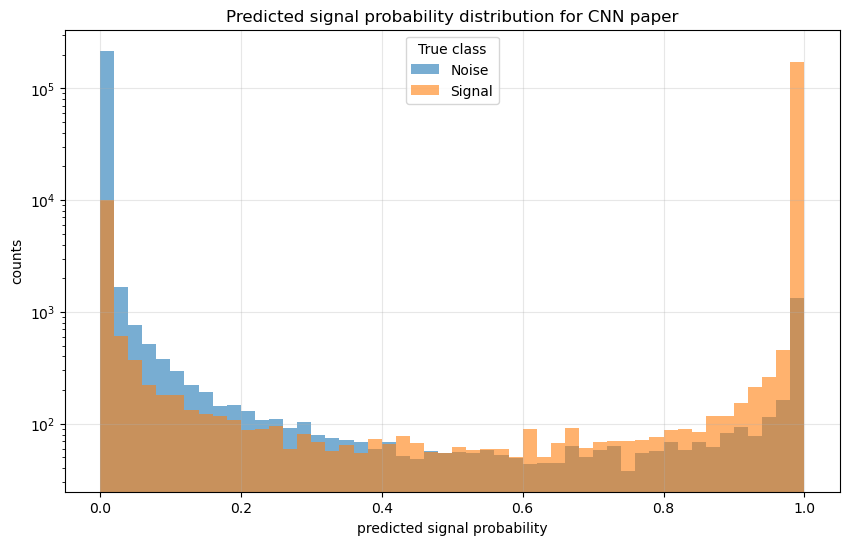

In [20]:
plot_PS('CNN paper', cnn_p_probs, cnn_p_labels)

In FAR computation, they only consider noise samples for which $P_S = 1$. In this case we have approximately $10^3$ noise samples classified as signals with $P_S = 1$. 

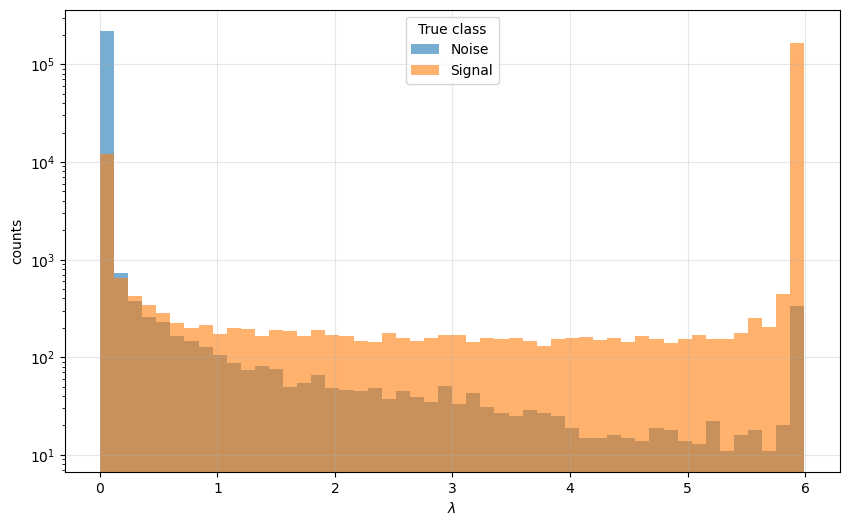

In [21]:
plot_PS_lambda('CNN paper', 0.999999*cnn_p_probs, cnn_p_labels)

## CNN

In [22]:
# model
class CNN(nn.Module):

    def __init__(self):
        super().__init__() 

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, 
                      out_channels=32, 
                      kernel_size=4, 
                      stride=1),
            nn.MaxPool1d(kernel_size=2, stride = 1), # default stride: kernel_size 
            nn.Dropout(0.1),
            nn.ReLU(True))
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, 
                      out_channels=64, 
                      kernel_size=4, 
                      stride=2),
            nn.MaxPool1d(kernel_size=2, stride = 1),
            nn.Dropout(0.1),
            nn.ReLU(True))
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=8, 
                      stride=2),
            nn.MaxPool1d(kernel_size=4, stride = 1),
            nn.Dropout(0.25),
            nn.ReLU(True))

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=128, 
                      out_channels=256, 
                      kernel_size=16, 
                      stride=4),
            nn.MaxPool1d(kernel_size=4, stride = 1),
            nn.Dropout(0.25),
            nn.ReLU(True),
            nn.AdaptiveAvgPool1d(1),
            nn.Dropout(0.1)
        )
        
        self.lin = nn.Sequential(
            nn.Linear(in_features=256, 
                      out_features=64),
            nn.Linear(in_features=64, 
                      out_features=n_classes))
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # apply conv layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.squeeze(-1) # remove last dim that is 1
        # apply linear layer
        out = self.lin(x)
        # apply softmax
        out = self.softmax(out)
        return out 

In [23]:
# retrieve model

cnn = CNN()
cnn.load_state_dict(torch.load(path+'CNN_trained.torch'))

cnn = cnn.to(device)

In [24]:
# testing
cnn.eval()
cnn_preds, cnn_labels, cnn_probs = [], [], []
with torch.no_grad():
    for sample in test_DL:
        xb = sample[0].float().to(device)
        yb = sample[1].long().to(device)

        out = cnn(xb)

        preds = torch.argmax(out, dim=1)

        cnn_preds.append(preds.cpu().numpy())
        cnn_labels.append(yb.cpu().numpy())
        cnn_probs.append(out.cpu().numpy())

cnn_preds = np.concatenate(cnn_preds)
cnn_labels = np.concatenate(cnn_labels)
cnn_probs = np.concatenate(cnn_probs)

In [25]:
# CM
cnn_cm = confusion_matrix(cnn_labels, cnn_preds)

In [26]:
cnn_cm

array([[221290,   3709],
       [ 14796, 172704]])

In [27]:
# ROC
cnn_fpr, cnn_tpr, cnn_auc = metrics.compute_roc(cnn_probs, cnn_labels, num_classes=n_classes)

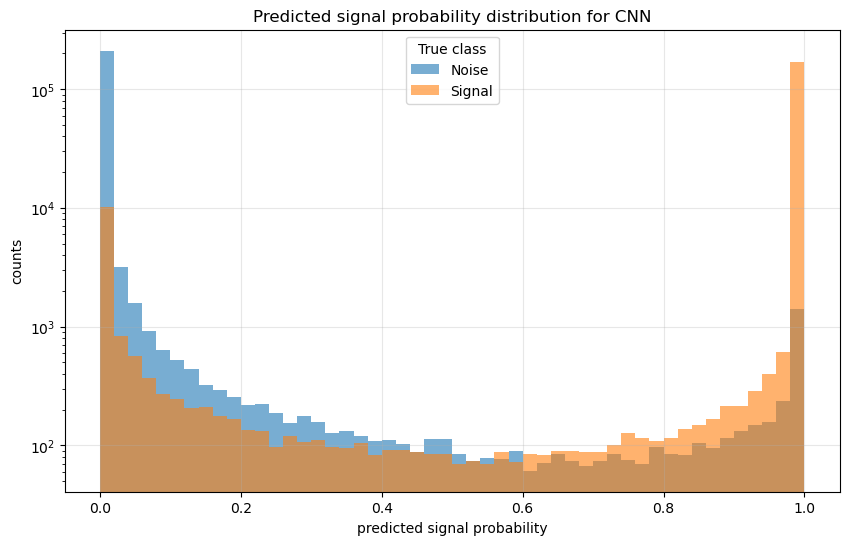

In [28]:
plot_PS('CNN', cnn_probs, cnn_labels)

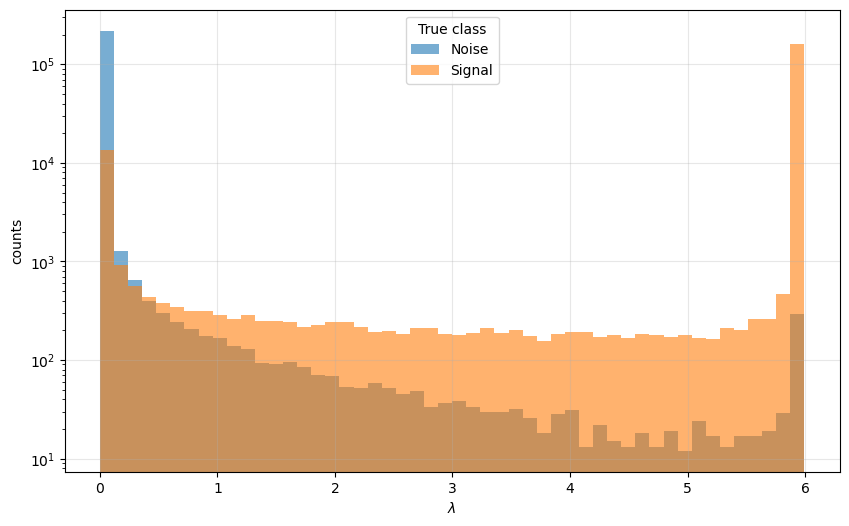

In [29]:
plot_PS_lambda('CNN', 0.999999*cnn_probs, cnn_labels)

## TCN

In [30]:
# model
class TempConvNet(nn.Module):
  def __init__(self,
               n_layers=8,          # number of dilated convolutional layers
               n_filters=32,        # number of filters in each conv layer
               filter_size=16,      # kernel size
               num_classes=n_classes        # number of classes to perform classification
               ):
    super().__init__()

    self.n_layers = n_layers
    self.n_filters = n_filters
    self.kernel_size = filter_size

    channels = np.full(n_layers,n_filters)

    self.tcn = TCN(
        num_inputs=1,
        num_channels=channels,
        kernel_size=filter_size,
        dropout=0.1
    )

    self.final_layer = nn.Sequential(
        nn.Dropout(0.1),
        nn.Linear(n_filters, num_classes),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    out = self.tcn(x)
    out = out[:,:,-1]
    out = self.final_layer(out)
    return out

  def compute_R(self):
    d_tot = 0
    for d in range(self.n_layers):
      d_tot += 2**(d+1)
    R = 1 + 2 * d_tot * (self.kernel_size-1)
    return R

In [31]:
# retrieve model
tcn = TempConvNet()
tcn.load_state_dict(torch.load(path+'TCN_trained.torch'))

tcn = tcn.to(device)

In [32]:
# testing
tcn.eval()
tcn_preds, tcn_labels, tcn_probs = [], [], []
with torch.no_grad():
    for sample in test_DL:
        xb = sample[0].float().to(device)
        yb = sample[1].long().to(device)

        out = tcn(xb)

        preds = torch.argmax(out, dim=1)

        tcn_preds.append(preds.cpu().numpy())
        tcn_labels.append(yb.cpu().numpy())
        tcn_probs.append(out.cpu().numpy())

tcn_preds = np.concatenate(tcn_preds)
tcn_labels = np.concatenate(tcn_labels)
tcn_probs = np.concatenate(tcn_probs)

In [33]:
# CM
tcn_cm = confusion_matrix(tcn_labels, tcn_preds)

In [34]:
tcn_cm

array([[222421,   2578],
       [  6833, 180667]])

In [35]:
# ROC
tcn_fpr, tcn_tpr, tcn_auc = metrics.compute_roc(tcn_probs, tcn_labels, num_classes=n_classes)

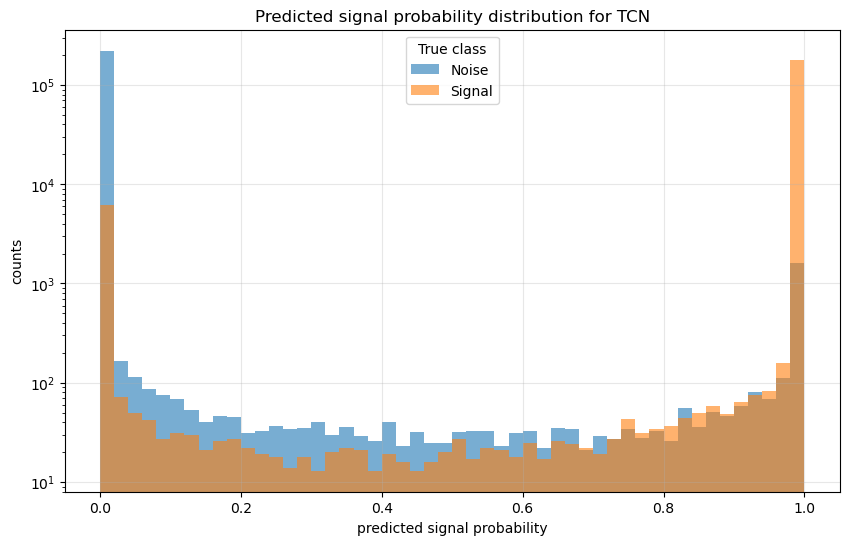

In [36]:
plot_PS('TCN', tcn_probs, tcn_labels)

## IT

In [37]:
# model

class InceptionModule(nn.Module):

    def __init__(self,
                 in_channels=1,
                 nb_filters=32, # number of conv filters in each branch of the IM
                 kernel_sizes=(10, 20, 40),
                 bottleneck_size=32):

        super().__init__()

        ### 1: bottleneck + conv branch ###
        # bottleneck
        self.bottleneck = nn.Conv1d(in_channels, bottleneck_size, kernel_size=1, bias=False)

        # parallel convolutions (3 branches, note that there is no bias)
        self.conv_list = nn.ModuleList()
        for k in kernel_sizes:
            self.conv_list.append(
                nn.Conv1d(bottleneck_size, nb_filters, kernel_size=k, padding='same', bias=False)
            )

        ### 2: maxpool branch: maxpool then convolution ###
        self.mp_branch = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, nb_filters, kernel_size=1, bias=False)
        )

        # output layer (to be applied to concatenated branches output)
        # concatenation applies along channel dimension
        # so we have to compute how many channels we have in total:
        #   - parallel convolution contribution: len(kernel_sizes) * nb_filters channels
        #   - maxpool branch contribution: nb_filters channels
        out_channels = nb_filters * (len(kernel_sizes) + 1)
        self.output_layer = nn.Sequential(
            nn.BatchNorm1d(out_channels), # output shape is same as input
            nn.ReLU()
        )

    def forward(self, x):

        # 1: bottleneck + conv branch
        x_b = self.bottleneck(x)
        conv_outs = [ conv(x_b) for conv in self.conv_list]

        # 2: maxpool branch
        mp = self.mp_branch(x)

        # concatenate branches outputs
        conv_outs.append(mp)
        out = torch.cat(conv_outs, dim=1)  # concat on channel dim
        # output
        out = self.output_layer(out)
        return out
    
class InceptionTime(nn.Module):
    def __init__(self,
                 in_channels=1,
                 depth=6,
                 nb_filters=32,
                 kernel_sizes=(10,20,40),
                 bottleneck_size=32,
                 num_classes=n_classes
                 ):
        super().__init__()

        self.depth = depth
        self.nb_filters = nb_filters
        self.kernel_sizes = kernel_sizes

        # first inception
        self.inception_1 = InceptionModule(in_channels=in_channels,
                                           nb_filters=nb_filters,
                                           kernel_sizes=kernel_sizes,
                                           bottleneck_size=bottleneck_size)

        # channel size after each inception
        self.out_channels = nb_filters * (len(kernel_sizes) + 1)

        # shortcut layer
        self.shortcut = nn.Sequential(
            nn.Conv1d(self.out_channels, self.out_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(self.out_channels),
            nn.ReLU()
        )

        # next inception module(s)
        self.inception = InceptionModule(in_channels=self.out_channels,
                                         nb_filters=nb_filters,
                                         kernel_sizes=kernel_sizes,
                                         bottleneck_size=bottleneck_size)

        # final classifier after residual blocks
        self.final_layer = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(), # since avg pool gives one dimension more
            nn.Linear(self.out_channels, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.inception_1(x)
        for d in range(self.depth-1):
            out = self.inception(out)
            if d % 3 == 2:  # residual connection every 3 modules
                out = self.shortcut(out)
        out = self.final_layer(out)
        return out

In [38]:
# retrieve model
it = InceptionTime()
it.load_state_dict(torch.load(path+'IT_trained.torch'))
it = it.to(device)

In [39]:
# testing
it.eval()
it_preds, it_labels, it_probs = [], [], []
with torch.no_grad():
    for sample in test_DL:
        xb = sample[0].float().to(device)
        yb = sample[1].long().to(device)

        out = it(xb)

        preds = torch.argmax(out, dim=1)

        it_preds.append(preds.cpu().numpy())
        it_labels.append(yb.cpu().numpy())
        it_probs.append(out.cpu().numpy())

it_preds = np.concatenate(it_preds)
it_labels = np.concatenate(it_labels)
it_probs = np.concatenate(it_probs)

/mnt/anaconda3/envs/nndl/lib/python3.9/site-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv1d(


In [40]:
# CM
it_cm = confusion_matrix(it_labels, it_preds)

In [41]:
it_cm

array([[159655,  65344],
       [  5025, 182475]])

In [42]:
# ROC
it_fpr, it_tpr, it_auc = metrics.compute_roc(it_probs, it_labels, num_classes=n_classes)

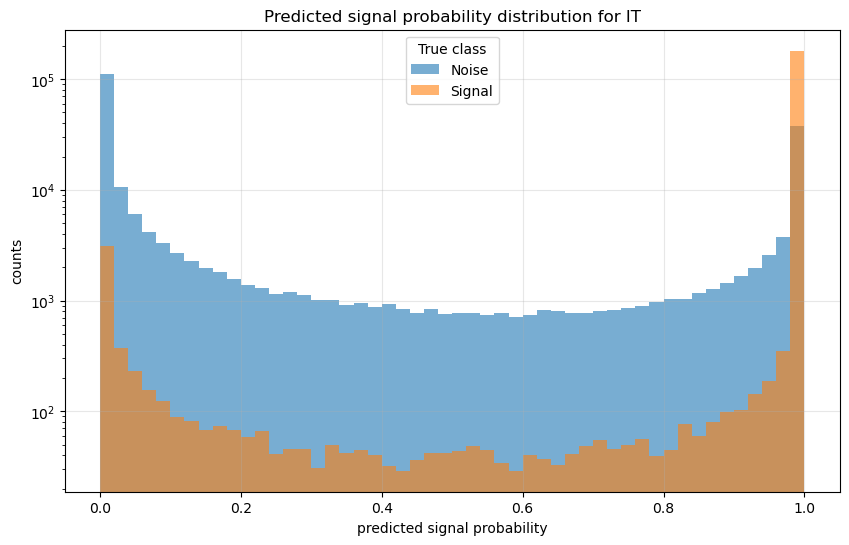

In [43]:
plot_PS('IT', it_probs, it_labels)

## Performance evaluation: ROC

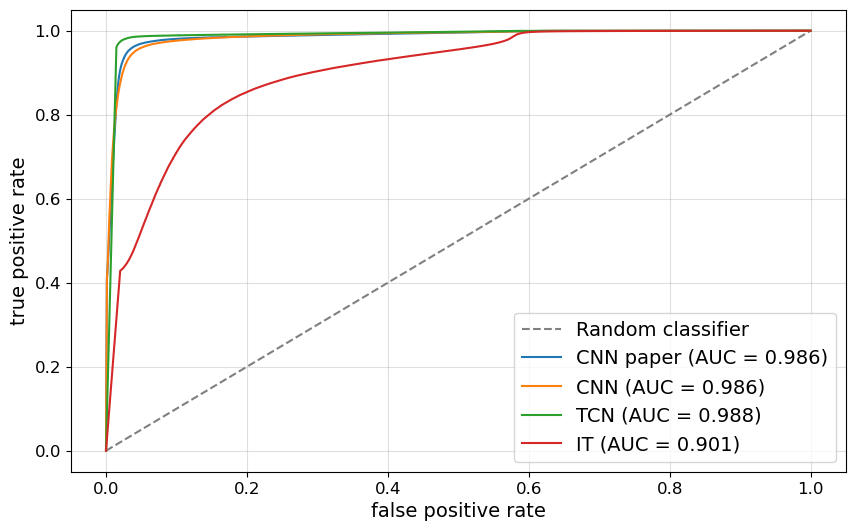

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
ax.grid(alpha = 0.4)

ax.set_ylabel('true positive rate', fontsize=14)
ax.set_xlabel('false positive rate', fontsize=14)
ax.plot([0,1], [0,1], label = 'Random classifier', linestyle = 'dashed', color = 'grey')

ax.plot(cnn_p_fpr["micro"], cnn_p_tpr["micro"], 
        label=f"CNN paper (AUC = {cnn_p_auc['micro']:.3f})")

ax.plot(cnn_fpr["micro"], cnn_tpr["micro"], 
        label=f"CNN (AUC = {cnn_auc['micro']:.3f})")

ax.plot(tcn_fpr["micro"], tcn_tpr["micro"], 
        label=f"TCN (AUC = {tcn_auc['micro']:.3f})")

ax.plot(it_fpr["micro"], it_tpr["micro"], 
        label=f"IT (AUC = {it_auc['micro']:.3f})")

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## PS evaluation

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18,6))

for i in range(3):
    ax[i].grid(alpha=0.3)


# inspect probs


plt.show()

## FAR evaluation

The final objective is to detect with high confidence the segments with a true astrophysical signal, i.e. to classify them as signal and to reject the other segments as noise/glitch. We aim to constrain false alarms to a rate of 2/day (similarly to the current online search pipelines). 

In [45]:
sec_in_day = 24*60*60
2/sec_in_day

2.3148148148148147e-05